Knudson et al., (2021). PyEI: A Python package for ecological inference. Journal of Open Source Software, 6(64), 3397, https://doi.org/10.21105/joss.03397

In [177]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from pyei import TwoByTwoEI


In [129]:
race_columns = {
    'WHITE': 'WHT_NHSP22',
    'BLACK': 'BLK_NHSP22',
    'HISPANIC': 'HSP_POP22',
    'ASIAN': 'ASN_NHSP22',
}
election_columns = {
    'REPUBLICAN': 'TOT_REP',
    'DEMOCRATIC': 'TOT_DEM',
}
income_columns = ['0_35K', '35K_60K', '60K_100K', '100K_125K', '125K_150K', '150K_MORE']

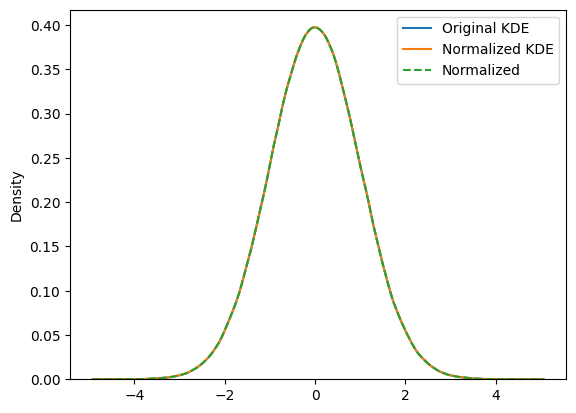

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
data = np.random.normal(loc=0, scale=1, size=10000)

# Plot KDE with normalization
sns.kdeplot(data, label="Original KDE", bw_adjust=1)

# Normalize KDE
kde = sns.kdeplot(data, bw_adjust=1, label="Normalized KDE")
kde_data = kde.get_lines()[0].get_data()
x, y = kde_data[0], kde_data[1]
y_normalized = y / np.trapz(y, x)  # Normalize by integrating over the curve
plt.plot(x, y_normalized, label="Normalized", linestyle="--")

plt.legend()
plt.show()


### Functions

In [192]:
def calculate_population_distribution(df, race_columns, columns_to_keep):
    # Recalculate total population as the sum of race-specific columns
    df['TOTAL_POP_RECALCULATED'] = df[list(race_columns.values())].sum(axis=1)
    
    # Calculate percentages for each race column
    for race, col in race_columns.items():
        percentage_col = f"{race}_PERCENT"
        df[percentage_col] = df[col] / df['TOTAL_POP_RECALCULATED']
    
    # Add the percentage columns to the columns_to_keep list
    columns_to_keep += [f"{race}_PERCENT" for race in race_columns.keys()]

    return df[columns_to_keep]




In [193]:
def calculate_voting_distribution(df, election_columns, columns_to_keep):
    df['TOTAL_VOTES_RECALCULATED'] = df[list(election_columns.values())].sum(axis=1)
    
    for party, col in election_columns.items():
        percentage_col = f"{party}_PERCENT"
        df[percentage_col] = (df[col] / df['TOTAL_VOTES_RECALCULATED'])
    columns_to_keep += [f"{party}_PERCENT" for party in election_columns.keys()]
    return df[columns_to_keep]

In [194]:
def calculate_income_distribution(df, income_columns, columns_to_keep):
    df['TOTAL_INCOME_POPULATION'] = df[income_columns].sum(axis=1)
    
    for income_range in income_columns:
        percentage_col = f"{income_range}_PERCENT"
        df[percentage_col] = df[income_range] / df['TOTAL_INCOME_POPULATION']
    
    columns_to_keep += [f"{income_range}_PERCENT" for income_range in income_columns]

    return df[columns_to_keep]

In [195]:
def run_ecological_inference(
    df, 
    demographic_col, 
    voting_col, 
    total_votes_col, 
    demographic_group_name="Demographic Group", 
    candidate_name="Candidate", 
    precinct_col="UNIQUE_ID",
    model_name="king99_pareto_modification",
    pareto_scale = 3,
    pareto_shape = 3,
):
    # Extract data
    X = np.array(df[demographic_col])  # Demographic percentage
    T = np.array(df[voting_col])       # Voting percentage
    N = np.array(df[total_votes_col])  # Total votes
    precinct_names = df[precinct_col]  # Precinct names

    ei = TwoByTwoEI(
        model_name=model_name,
        pareto_scale=pareto_scale,
        pareto_shape=pareto_shape
    )

    # Fit the model
    ei.fit(
        X, T, N,
        demographic_group_name=demographic_group_name,
        candidate_name=candidate_name,
        precinct_names=precinct_names,
        # draws=8000,
        # tune=4000,
        # target_accept=0.95
    )

    # Display a summary
    summary = ei.summary()
    print(summary)

    return ei, summary


## South Carolina

### Import data

In [196]:
sc_election_gov_df = pd.read_json('states/south_carolina/election/sc_election_gov_22.json')
sc_race_df = pd.read_json('states/south_carolina/demographics/south_carolina_precincts_racial_population.json')
sc_economic_df = pd.read_json('states/south_carolina/economic/south_carolina_precincts_household_income.json')
sc_region_type_df = pd.read_json('states/south_carolina/geodata/south_carolina_precincts_region_type.json')

In [221]:
sc_candidate_mapping = {
    'REPUBLICAN': 'Henry McMaster',
    'DEMOCRATIC': 'Joe Cunningham (Democrat)'
}

### Main Script

#### Preprocess data

##### Racial Group

In [198]:
print(sc_race_df.columns.values)

['UNIQUE_ID' 'NAME' 'Prec_Code' 'CONG_DIST' 'TOT_POP22' 'NHSP_POP22'
 'HSP_POP22' 'WHT_NHSP22' 'BLK_NHSP22' 'ASN_NHSP22' 'OTH_NHSP22']


In [199]:
columns_to_keep = ['UNIQUE_ID', 'TOT_POP22']

In [200]:
sc_race_with_percentages = calculate_population_distribution(sc_race_df, race_columns, columns_to_keep)

In [201]:
columns_to_keep = ['UNIQUE_ID', 'TOT_VOT']

In [202]:
sc_election_gov_with_percentages = calculate_voting_distribution(sc_election_gov_df, election_columns, columns_to_keep)

In [203]:
sc_race_merged_ei_df = pd.merge(sc_election_gov_with_percentages, sc_race_with_percentages, on='UNIQUE_ID', how='left')

In [204]:
sc_race_merged_ei_df.fillna(0, inplace=True)

In [205]:
print(sc_race_merged_ei_df)

                    UNIQUE_ID  TOT_VOT  REPUBLICAN_PERCENT  \
0     ABBEVILLE_PRECINCT_001_      975            0.736410   
1     ABBEVILLE_PRECINCT_002_      628            0.356688   
2     ABBEVILLE_PRECINCT_003_      574            0.585366   
3     ABBEVILLE_PRECINCT_004_      437            0.723112   
4     ABBEVILLE_PRECINCT_005_      722            0.829640   
...                       ...      ...                 ...   
2256  CLARENDON_PRECINCT_024_      600            0.430000   
2257   BARNWELL_PRECINCT_016_        0            0.000000   
2258   BERKELEY_PRECINCT_099_        0            0.000000   
2259   BERKELEY_PRECINCT_098_        0            0.000000   
2260      AIKEN_PRECINCT_000_        0            0.000000   

      DEMOCRATIC_PERCENT  TOT_POP22  WHITE_PERCENT  BLACK_PERCENT  \
0               0.263590       1290       0.651800       0.348200   
1               0.643312        901       0.088790       0.826859   
2               0.414634       1297       0.4968

In [206]:
# print max value of BLACK_PERCENT
print(sc_race_merged_ei_df['BLACK_PERCENT'].min())

0.0


In [207]:
print(sc_race_merged_ei_df.columns.values)

['UNIQUE_ID' 'TOT_VOT' 'REPUBLICAN_PERCENT' 'DEMOCRATIC_PERCENT'
 'TOT_POP22' 'WHITE_PERCENT' 'BLACK_PERCENT' 'HISPANIC_PERCENT'
 'ASIAN_PERCENT']


In [208]:
# sc_race_merged_ei_df = normalize_percent_columns(sc_race_merged_ei_df)

In [209]:
sc_race_merged_ei_df = sc_race_merged_ei_df[sc_race_merged_ei_df['TOT_VOT']>0]

In [243]:
sc_race_merged_ei_df = sc_race_merged_ei_df.sample(n=100, random_state=42)

In [244]:
sc_race_merged_ei_df

,UNIQUE_ID,TOT_VOT,REPUBLICAN_PERCENT,DEMOCRATIC_PERCENT,TOT_POP22,WHITE_PERCENT,BLACK_PERCENT,HISPANIC_PERCENT,ASIAN_PERCENT
561,CHARLESTON_PRECINCT_518_,765,0.250980,0.749020,2262,0.541346,0.356731,0.044231,0.057692
440,CHARLESTON_PRECINCT_102_,421,0.327791,0.672209,2243,0.235206,0.577733,0.183049,0.004012
1513,LEXINGTON_PRECINCT_073_,1187,0.689975,0.310025,5771,0.868199,0.069147,0.037557,0.025097
1360,KERSHAW_PRECINCT_152_,762,0.778215,0.221785,2780,0.840295,0.159705,0.000000,0.000000
259,BEAUFORT_PRECINCT_205_,1164,0.647766,0.352234,3665,0.625139,0.093437,0.279199,0.002225
...,...,...,...,...,...,...,...,...,...
1340,KERSHAW_PRECINCT_117_,828,0.556763,0.443237,3227,0.601703,0.398297,0.000000,0.000000
965,GEORGETOWN_PRECINCT_131_,442,0.201357,0.798643,746,0.105898,0.564343,0.329759,0.000000
70,AIKEN_PRECINCT_055_,532,0.716165,0.283835,621,0.986301,0.000000,0.000000,0.013699
845,EDGEFIELD_PRECINCT_012_,1692,0.817967,0.182033,5315,0.823045,0.081521,0.095434,0.000000


##### Economic Group

In [254]:
columns_to_keep = ['UNIQUE_ID']

In [255]:
sc_economic_with_percentages = calculate_income_distribution(sc_economic_df, income_columns, columns_to_keep)

In [256]:
sc_economic_merged_ei_df = pd.merge(sc_election_gov_with_percentages, sc_economic_with_percentages, on='UNIQUE_ID', how='left')

In [257]:
sc_economic_merged_ei_df.fillna(0, inplace=True)

In [259]:
sc_economic_merged_ei_df = sc_economic_merged_ei_df[sc_economic_merged_ei_df['TOT_VOT']>0]

In [260]:
sc_economic_merged_ei_df = sc_economic_merged_ei_df.sample(n=100, random_state=42)

### Running EI models

#### Racial Run

##### DEMOCRATIC Run

In [245]:
dem_white_ei, dem_white_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="WHITE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:03.080401
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.521971
Transforming variables...
Transformation time = 0:00:22.462600


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Joe Cunningham (Democrat) is
        0.263
        The posterior mean for the district-level voting preference of
        non-White for Joe Cunningham (Democrat) is
        0.651
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Joe Cunningham (Democrat) is
        [0.2245569  0.30737582]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Joe Cunningham (Democrat) is
        [0.57285803 0.72162231]
        


In [246]:
dem_black_ei, dem_black_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="BLACK_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:02.555445
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.762326
Transforming variables...
Transformation time = 0:00:23.105118


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Joe Cunningham (Democrat) is
        0.854
        The posterior mean for the district-level voting preference of
        non-Black for Joe Cunningham (Democrat) is
        0.287
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Joe Cunningham (Democrat) is
        [0.7750341  0.91923639]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Joe Cunningham (Democrat) is
        [0.27219722 0.30591704]
        


In [247]:
dem_asian_ei, dem_asian_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:02.463023
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.118431
Transforming variables...
Transformation time = 0:00:46.123721


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Joe Cunningham (Democrat) is
        0.598
        The posterior mean for the district-level voting preference of
        non-Asian for Joe Cunningham (Democrat) is
        0.384
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Joe Cunningham (Democrat) is
        [0.11634365 0.97136226]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Joe Cunningham (Democrat) is
        [0.37760433 0.39132542]
        


In [248]:
dem_hispanic_ei, rep_asian_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:02.347511
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.604256
Transforming variables...
Transformation time = 0:00:22.637661


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Joe Cunningham (Democrat) is
        0.811
        The posterior mean for the district-level voting preference of
        non-Hispanic for Joe Cunningham (Democrat) is
        0.364
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Joe Cunningham (Democrat) is
        [0.59990126 0.96557574]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Joe Cunningham (Democrat) is
        [0.35513938 0.37633383]
        


##### Running Repulican

In [249]:
rep_white_ei, rep_white_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="WHITE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:02.322456
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.229933
Transforming variables...
Transformation time = 0:00:22.733070


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Henry McMaster is
        0.739
        The posterior mean for the district-level voting preference of
        non-White for Henry McMaster is
        0.346
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Henry McMaster is
        [0.69749281 0.77651381]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Henry McMaster is
        [0.27351256 0.42315422]
        


In [250]:
rep_black_ei, rep_black_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="BLACK_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:02.504105
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.050483
Transforming variables...
Transformation time = 0:00:25.416755


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Henry McMaster is
        0.144
        The posterior mean for the district-level voting preference of
        non-Black for Henry McMaster is
        0.713
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Henry McMaster is
        [0.07966281 0.22670706]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Henry McMaster is
        [0.69545017 0.72794267]
        


In [251]:
rep_asian_ei, rep_asian_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:06.366322
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:05.176569
Transforming variables...
Transformation time = 0:00:17.162863


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Henry McMaster is
        0.436
        The posterior mean for the district-level voting preference of
        non-Asian for Henry McMaster is
        0.615
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Henry McMaster is
        [0.01673368 0.91448668]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Henry McMaster is
        [0.60828897 0.6224576 ]
        


In [252]:
rep_hispanic_ei, rep_hispanic_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.840508
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.860007
Transforming variables...
Transformation time = 0:00:27.465999


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Henry McMaster is
        0.131
        The posterior mean for the district-level voting preference of
        non-Hispanic for Henry McMaster is
        0.639
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Henry McMaster is
        [0.00676229 0.37473169]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Henry McMaster is
        [0.62494847 0.64693357]
        


#### Econ Run

##### Dem Run

In [261]:
dem_0_35_ei, dem_0_35_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="0_35K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.936973
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.803327
Transforming variables...
Transformation time = 0:00:24.173964


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Joe Cunningham (Democrat) is
        0.685
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Joe Cunningham (Democrat) is
        0.308
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Joe Cunningham (Democrat) is
        [0.57221456 0.77806827]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Joe Cunningham (Democrat) is
        [0.28083779 0.33943272]
        


In [262]:
dem_35_60_ei, dem_35_60_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:04.353899
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.102216
Transforming variables...
Transformation time = 0:00:21.767096


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democrat) is
        0.700
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democrat) is
        0.328
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democrat) is
        [0.55190432 0.82957474]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democrat) is
        [0.30299803 0.35729702]
        


In [263]:
dem_60_100_ei, dem_60_100_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:02.045650
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.230755
Transforming variables...
Transformation time = 0:00:24.211443


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democrat) is
        0.548
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democrat) is
        0.343
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democrat) is
        [0.36185628 0.70095085]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democrat) is
        [0.30275056 0.39156457]
        


In [264]:
dem_100_125_ei, dem_100_125_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:02.659936
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.652350
Transforming variables...
Transformation time = 0:00:12.399776


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Joe Cunningham (Democrat) is
        0.595
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Joe Cunningham (Democrat) is
        0.367
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Joe Cunningham (Democrat) is
        [0.24833837 0.88434536]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Joe Cunningham (Democrat) is
        [0.3417935  0.39540358]
        


In [265]:
dem_125_150_ei, dem_125_150_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.571215
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.579307
Transforming variables...
Transformation time = 0:00:28.162670


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Joe Cunningham (Democrat) is
        0.319
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Joe Cunningham (Democrat) is
        0.388
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Joe Cunningham (Democrat) is
        [0.06682446 0.68593993]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Joe Cunningham (Democrat) is
        [0.36323266 0.40632939]
        


In [266]:
dem_150_more_ei, dem_150_more_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.653421
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.331623
Transforming variables...
Transformation time = 0:00:21.809069


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Joe Cunningham (Democrat) is
        0.393
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Joe Cunningham (Democrat) is
        0.383
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Joe Cunningham (Democrat) is
        [0.14084332 0.63951373]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Joe Cunningham (Democrat) is
        [0.33892029 0.43050575]
        


##### Rep Run

In [267]:
rep_0_35_ei, rep_0_35_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="0_35K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.796344
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.549896
Transforming variables...
Transformation time = 0:00:26.511082


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Henry McMaster is
        0.312
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Henry McMaster is
        0.693
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Henry McMaster is
        [0.21707886 0.42527423]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Henry McMaster is
        [0.66027221 0.71922325]
        


In [268]:
rep_35_60_ei, rep_35_60_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.848939
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.816927
Transforming variables...
Transformation time = 0:00:19.577997


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Henry McMaster is
        0.294
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster is
        0.673
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Henry McMaster is
        [0.16964549 0.43488283]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster is
        [0.64574003 0.69689868]
        


In [269]:
rep_60_100_ei, rep_60_100_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.623467
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.600556
Transforming variables...
Transformation time = 0:00:25.561677


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Henry McMaster is
        0.440
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster is
        0.660
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Henry McMaster is
        [0.29071485 0.60227286]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster is
        [0.61787471 0.69846859]
        


In [270]:
rep_100_125_ei, rep_100_125_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.978875
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.545435
Transforming variables...
Transformation time = 0:00:16.081628


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Henry McMaster is
        0.401
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Henry McMaster is
        0.634
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Henry McMaster is
        [0.14282534 0.7182722 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Henry McMaster is
        [0.60714389 0.65547195]
        


In [271]:
rep_125_150_ei, rep_125_150_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.618964
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.296899
Transforming variables...
Transformation time = 0:00:17.584833


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Henry McMaster is
        0.710
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Henry McMaster is
        0.610
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Henry McMaster is
        [0.31216322 0.98286818]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Henry McMaster is
        [0.58998571 0.63750361]
        


In [272]:
rep_150_more_ei, rep_150_more_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.864505
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.132689
Transforming variables...
Transformation time = 0:00:20.946627


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Henry McMaster is
        0.584
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Henry McMaster is
        0.621
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Henry McMaster is
        [0.36926494 0.83357512]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Henry McMaster is
        [0.5748853  0.66119355]
        


### Ploting

<Axes: title={'center': 'Support for Joe Cunningham (Democrat)'}>

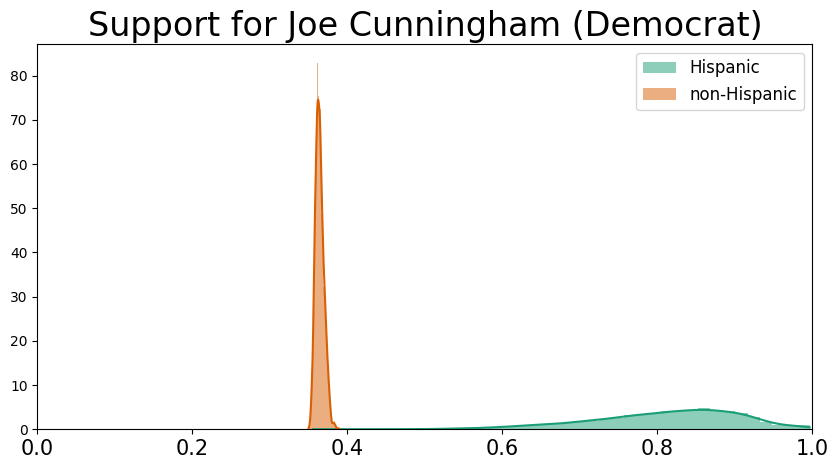

In [284]:
dem_hispanic_ei.plot_kde()

# Plot the ecological inference results



### Export data